In [1]:

using Pkg
Pkg.add("Plots")
using Plots
using Optim


    Updating registry at `C:\Users\bensp\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\CMU_Spring\OptimalSailboat\Project.toml`
  No Changes to `C:\CMU_Spring\OptimalSailboat\Manifest.toml`


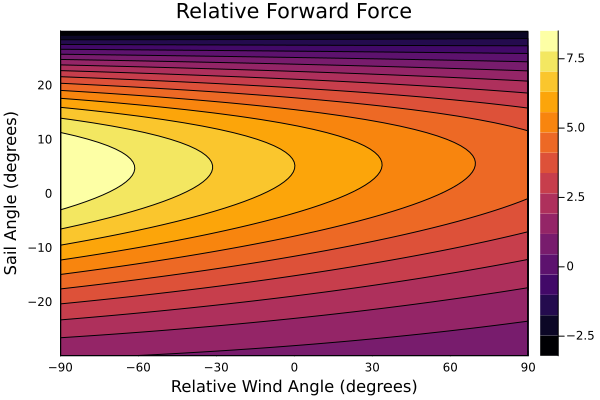

48.105637508093714

In [7]:
# Refering the following paper for the model
# Roll Stabilization Control of Sailboats
# https://www.sciencedirect.com/science/article/pii/S2405896316320833

# Assuming Constant Wind Speed
V_ws = 5.0  # m/s, example constant wind speed
# Setting some global variables for the sailboat
A = 1  # m^2, sail area
l1 = 1  # m, distance from the center of mass to the sail
l2 = 1  # m, distance from the center of mass to the rudder
h = 1  # m, height of the sail



function angle_of_attack(λ, βws)
    # Calculate the angle of attack
    α = βws - λ + π
    return α
end

function CL(α)
    # Calculate the lift coefficient
    # This is a simple model that assumes lift is proportional to the angle of attack
    # will be different for different sailboats 
    return α
end

function CD(α)
    # Calculate the drag coefficient
    # This is a simple model that assumes drag is proportional to the square of the angle of attack
    # will be different for different sailboats 
    return α^2
end

function SL_(Vws, A,λ, βws)
    # Calculate the lift force
    ρ = 1.225  # kg/m^3, air density
    Fl = 0.5 * ρ * Vws^2 * A * CL(angle_of_attack(λ, βws))
    return Fl

end

function SD_(Vws, A, λ, βws)
    # Calculate the drag force
    ρ = 1.225  # kg/m^3, air density
    Fd = 0.5 * ρ * Vws^2 * A * CD(angle_of_attack(λ, βws))
    return Fd
end

print(SL_(5, 1, 0, 0))


function Sail_forces(Vws, A, λ, βws, h,l1,l2)
    # Calculate the forces on the sail
    SL = SL_(Vws, A, λ, βws)
    SD = SD_(Vws, A, λ, βws)
    S1 = -SL * sin(βws) + SD * cos(βws)
    S2 = SL * cos(βws) + SD * sin(βws)
    S3 = h*S2
    S4 = S1*(l2 * sin(λ))- S2*(l1 + l2 * cos(λ))

    S = [S1, S2, S3, S4]'
    return S
end

# Function to calculate S'_{x,r}
function S_prime_x_r(Vws, A, λ, βws, h, l1, l2)
    S = Sail_forces(Vws, A, λ, βws, h, l1, l2)
    # Here S[1] represents S1, the force in the surge direction
    S_prime_x_r = S[1] / Vws^2
    return S_prime_x_r
end

# Create ranges for relative wind angle and sail angle
βws_values = range(deg2rad(-90), deg2rad(90), length=100)  # Relative wind angle
λ_values = range(deg2rad(-30), deg2rad(30), length=100)    # Sail angle

# Compute the normalized forces for the contour plot
Z = [S_prime_x_r(V_ws, A, λ, βws, h, l1, l2) for βws in βws_values, λ in λ_values]

# Create a contour plot of the relative forward force
p = contour(βws_values .* 180 / π, λ_values .* 180 / π, Z,
            title="Relative Forward Force",
            xlabel="Relative Wind Angle (degrees)",
            ylabel="Sail Angle (degrees)",
            fill=true)

# Display the plot
display(p)


# To find the optimal sail angle, we will optimize over S'_x_r for a given wind speed to find the optimal sail angle defined: λ_opt
# This will be done with a lookup table of the sailboat's polar diagram




In [12]:

# Defining the bounds for the sail angle λ based on the wind angle βws and the saturation limit λ_sat
function λ_bounds(βws, λ_sat)
    if βws < 0
        λ_u = βws + π
        λ_l = 0
    elseif βws > 0
        λ_u = 0
        λ_l = βws - π
    else # Handling the case when βws is 0
        λ_u = 0
        λ_l = -π
    end
    # Apply saturation limits
    λ_u = min(λ_u, λ_sat)
    λ_l = max(λ_l, -λ_sat)
    return λ_l, λ_u
end

function compute_lookup_table(V_ws, A, h, l1, l2, βws_values, λ_sat)
    # Create a lookup table to store the optimal sail angle for each wind angle
    λ_opt_values = Dict()

    # Iterate through all wind angles βws
    for βws in βws_values
        # Get the bounds for λ
        λ_l, λ_u = λ_bounds(βws, λ_sat)

        # Optimize to find λ that maximizes S'_x_r within the bounds
        opt_result = optimize(λ -> -S_prime_x_r(V_ws, A, λ, βws, h, l1, l2), λ_l, λ_u)
        λ_opt = opt_result.minimizer

        # Store the result in the lookup table
        λ_opt_values[βws] = λ_opt
    end
    return λ_opt_values
end


compute_lookup_table (generic function with 3 methods)

In [16]:
λ_sat = π / 4  # standatd saturation limit for the sail angle
βws_values = range(deg2rad(-180), stop=deg2rad(180), length=360) # Wind angles from -180 to 180 degrees in radians

optimal_angle = compute_lookup_table(V_ws, A, h, l1, l2, βws_values, λ_sat)



Dict{Any, Any} with 360 entries:
  0.498804  => -0.785398
  1.58392   => -7.0466e-16
  -0.936352 => 7.0466e-16
  1.74144   => -1.40108e-15
  1.11137   => -0.785398
  -0.148766 => 7.0466e-16
  0.27128   => -0.785398
  -1.3739   => 4.82616e-16
  2.49402   => -9.4008e-16
  0.971356  => -0.785398
  -2.05647  => 0.137878
  2.42401   => -1.4408e-15
  2.03897   => -1.84482e-15
  -0.971356 => 4.82616e-16
  1.61893   => -1.83117e-15
  -2.42401  => 0.281182
  -0.726329 => 6.99444e-16
  -2.44152  => 0.278867
  2.21399   => -1.84482e-15
  ⋮         => ⋮